# Using `timecorr`

`timecorr` is used to approximate dynamic high-order correlations.  There are two steps to `timecorr`:

1.  Calculate dynamic correlations  
2.  Dimensionally reduce back to the original size of the data

By repeating these steps, you can approximate higher-order correlations in a computationally tractable way.  Although both of these steps can be accomplished in just a single, we'll go through and break it down.


# Load in required libraries

In [1]:
import timecorr as tc
import numpy as np
import seaborn as sns
import warnings 
warnings.simplefilter("ignore")
%matplotlib inline

# Simulate some data


First, we'll use the built in simulation function to simulate some timeseries. By default, the `simulate_data` function will return a 100 samples from 1 subject, using ramping data generation function with 10 features and 5 blocks, but you can specify the number of time samples with `T`, the number of subjects with `S`, and number of features with `K`.  You can also set a random seed to get consistent results across simulations.  If you want further information on simulating data, check out the simulate API page.

In [17]:
# simulate 1 subject's timeseries 
sim_1 = tc.simulate_data(S=1, T=200, K=300, set_random_seed=100)

In [19]:
# output for 1 subject is an array
print('shape : ' + str(np.shape(sim_1)))
print('type : ' + str(type(sim_1)))

shape: (200, 300)
sim_data: <class 'numpy.ndarray'>


In [21]:
# simulate 3 subjects' timeseries
sim_3 = tc.simulate_data(S=3, T=200, K=300, set_random_seed=100)

In [24]:
# output for 3 subjects is a list of arrays
print('shape : ' + str(np.shape(sim_3)))
print('type : ' + str(type(sim_3)))
print('type for sim_3[0] : ' + str(type(sim_3[0])))

shape : (3, 200, 300)
type : <class 'list'>
type for sim_3[0] : <class 'numpy.ndarray'>


# Calculate dynamic correlations

Now that we have a list of arrays of simulated timeseries data, we can start using `timecorr`.  Let's start by going over the way we calculate dynamic correlations. We use a kernel based approach, and you can specify but the type of kernel with `weights_function` and the width with `weights_params` that you want to use to calculate the correlations.  

For this example, we're going to use a gaussian kernel and a width of 5.  Here's how:

In [45]:
# specify kernel:
width = 5
gaussian = {'name': 'Gaussian', 'weights': tc.gaussian_weights, 'params': {'var': width}}

# calcuate the dynamic correlations use a gaussian kernel and width of 5 for 1 simulate subject
vec_corrs = tc.timecorr(sim_1, weights_function=gaussian['weights'], weights_params=gaussian['params'])

`timecorr` returns a vectorized version of the correlation matrices. Specifically, the upper triangle of correlation matrices. If you want the full correlation matrices, use the `vec2mat` function. Also, `mat2vec` converts them back to the vectorized version.  

In [46]:
# returns moment-by-moment correlations, but just the upper triangle for the matrices
print('vectorized shape : ' + str(np.shape(vec_corrs)))

# use the vec2mat function to convert vectorized correlations to moment-by-moment full correlations 
mat_corrs = tc.vec2mat(vec_corrs)

# return the dynamic full correlations
print('matrix shape : ' + str(np.shape(mat_corrs)))

vectorized shape : (200, 45150)
matrix shape : (300, 300, 200)


Let's plot one of these full correlation matrices. 

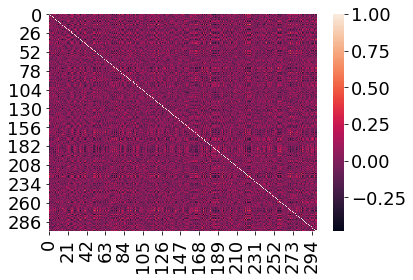

In [47]:
sns.heatmap(mat_corrs[:, :, 100])

Ok let's now calculate the dynamic correlations for for the 3 simulated subjects. The default `cfun` calculates a continuous verison of Inter-Subject Functional Connectivity (Simony et al. 2017). If only one data array is passed (rather than a list), the default cfun returns the moment-by-moment correlations for that array. The default for the `combine` function is none, but for this example we'll use `corrmean_combine` which calcuates the average correlations across matrices.  For more information on the different function options, please check out the API documenation.  

In [49]:
# calcuate the dynamic isfc correlations use a Laplace kernel 
# and width of 10 for 3 simulated subjects, and take the element-wise average correlations across matrices.
width = 10
laplace = {'name': 'Laplace', 'weights': tc.laplace_weights, 'params': {'scale': width}}

dyna_corrs = tc.timecorr(sim_3, combine=tc.corrmean_combine, 
                         weights_function=laplace['weights'], weights_params=laplace['params'])

In [51]:
# again, this returns the vectorized version of the dynamic correlations
print('vectorized shape : ' + str(np.shape(dyna_corrs)))

vectorized shape : (200, 45150)


# Higher order correlations

Ok, now that we've gone over how to calculate dynamic correlations, let's walk through reducing the correlations back to the original size of the data using the `rfun` parameter.  Again, you have several options.  If you want more information, please checkout the API documentation.  

The default for `rfun` is `None`, which we used for calculating the dynamic correlations, but in this example we'll use `PCA`.  


In [55]:
# approximate the dynamic isfc correlation, using a Laplace kernel, width 10, and reducing using PCA
width = 10
laplace = {'name': 'Laplace', 'weights': tc.laplace_weights, 'params': {'scale': width}}

dyna_corrs_reduced = tc.timecorr(sim_3, rfun='PCA', 
                                 weights_function=laplace['weights'], weights_params=laplace['params'])

In [56]:
# this returns the approximated dynamic correlations the same size as the original data
print('original shape : ' + str(np.shape(sim_3)))
print('reduced shape : ' + str(np.shape(dyna_corrs_reduced)))

original shape : (3, 200, 300)
reduced shape : (3, 200, 300)


To calculate higher-order correlations, you can repeat this process up to any order you want.  For example, if we want to calculate correlations up to the second order, we repeat this process twice. 

In [57]:
order_0 = sim_3

order_1 = tc.timecorr(order_0, rfun='PCA', weights_function=laplace['weights'], weights_params=laplace['params'])

order_2 = tc.timecorr(order_1, rfun='PCA', weights_function=laplace['weights'], weights_params=laplace['params'])


Ok, and that's it!